<a href="https://colab.research.google.com/github/Cimbir/Store-Sales-Forecasting/blob/main/model_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 90.9 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: /root/.kaggle: Is a directory


In [3]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 713MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [4]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import pickle

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Evaluate

In [8]:
def WMAE(dataset, real, predict):
    weights = dataset['IsHoliday_x'].apply(lambda x: 5 if x else 1)
    return (np.sum(weights * abs(real - predict)) / np.sum(weights))

# Get Data

In [9]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [10]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)

display(df.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


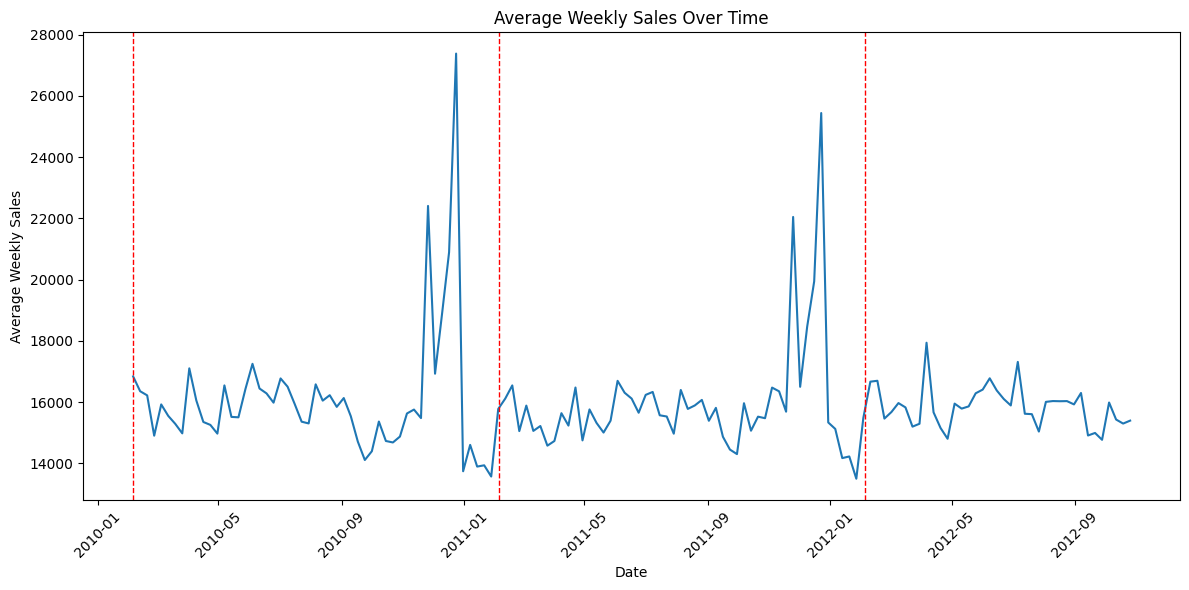

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
avg_sales_over_time = df.groupby('Date')['Weekly_Sales'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_sales_over_time.index, avg_sales_over_time.values)
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

plt.show()

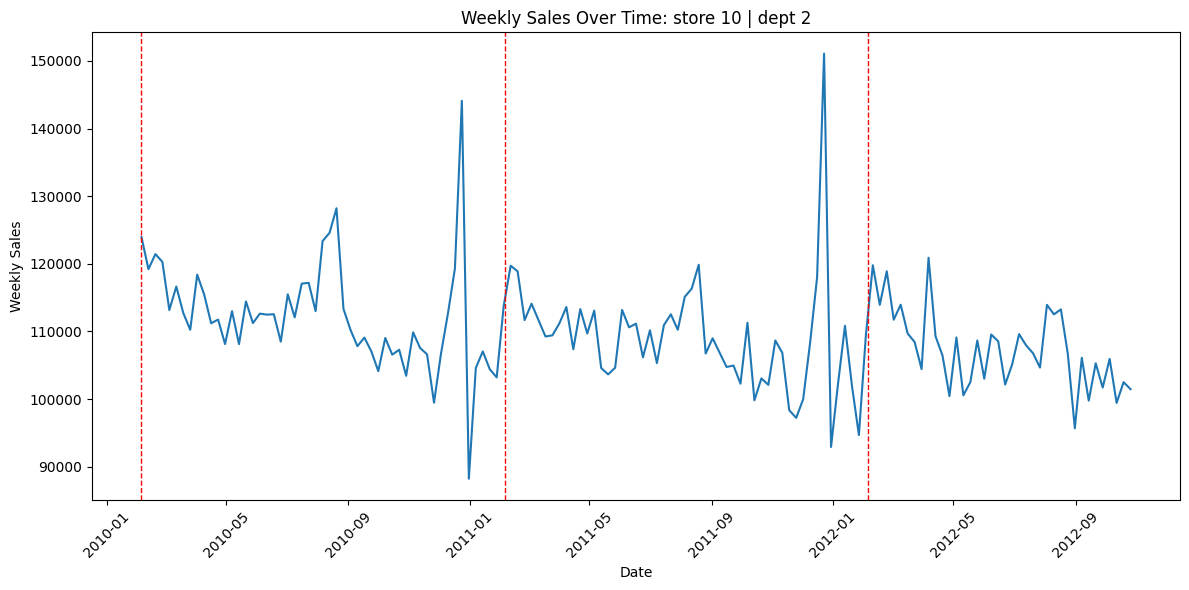

In [15]:
store_id = 10
dept_id = 2

df['Date'] = pd.to_datetime(df['Date'])
store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]
store_sales_over_time = store_dept_df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(store_sales_over_time.index, store_sales_over_time.values)
plt.xlabel('Date')
plt.ylabel(f'Weekly Sales')
plt.title(f'Weekly Sales Over Time: store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(store_sales_over_time.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

plt.show()

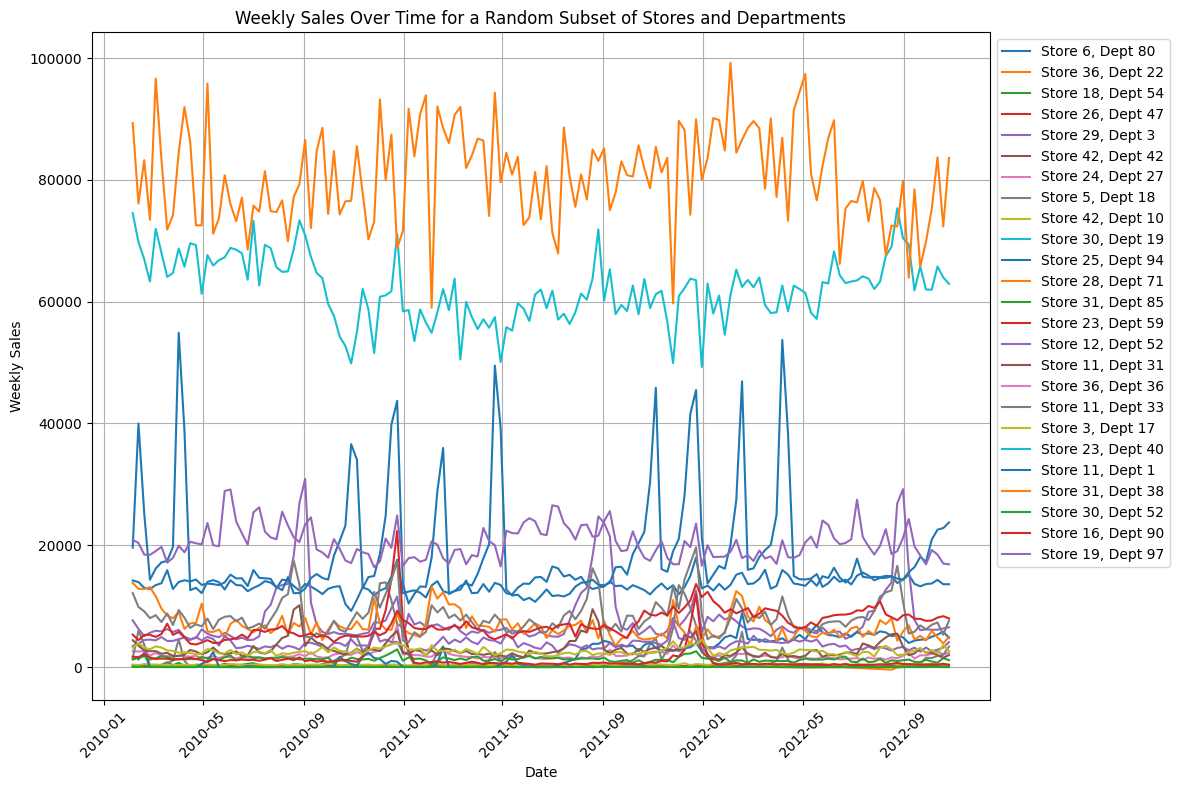

In [16]:
import random

# Get all unique store and department combinations
unique_store_dept = df[['Store', 'Dept']].drop_duplicates()

# Select a random subset of store and department combinations
subset_size = 25  # You can adjust the size of the subset
random_subset_store_dept = unique_store_dept.sample(n=subset_size, random_state=42) # Using random_state for reproducibility

plt.figure(figsize=(14, 8))

for index, row in random_subset_store_dept.iterrows():
    store_id = row['Store']
    dept_id = row['Dept']

    # Filter data for the current store and department
    store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]

    # Sort by date for proper plotting
    store_dept_df = store_dept_df.sort_values('Date')

    plt.plot(store_dept_df['Date'], store_dept_df['Weekly_Sales'], label=f'Store {store_id}, Dept {dept_id}')

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Over Time for a Random Subset of Stores and Departments')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
plt.grid(True)
plt.show()

# Remove Trend

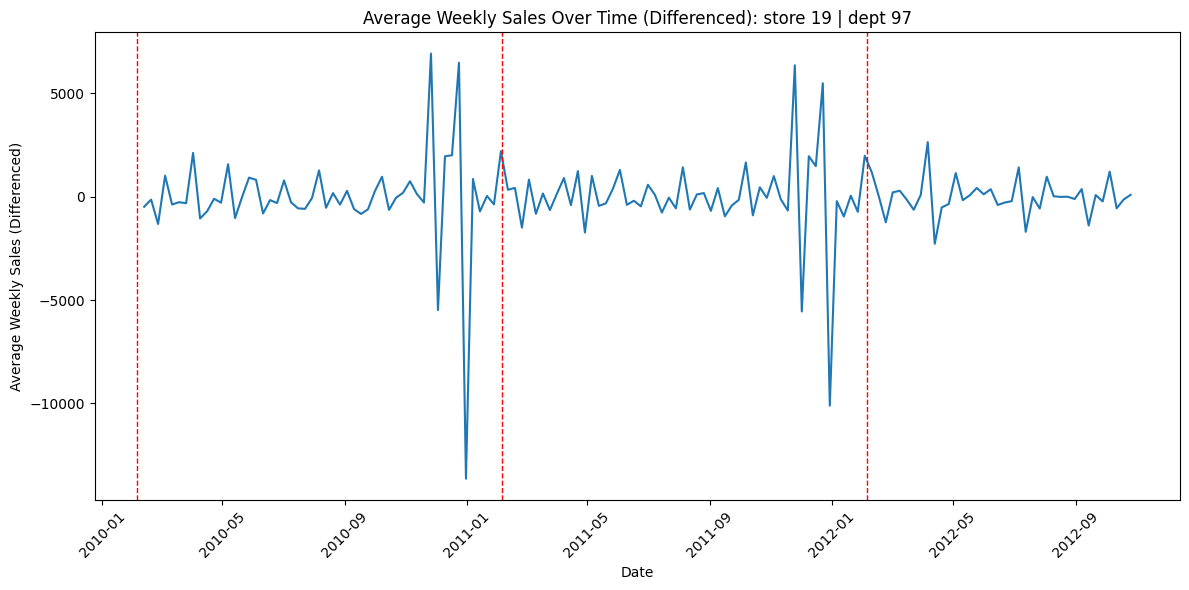

In [17]:
avg_sales_over_time_diff = avg_sales_over_time.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(avg_sales_over_time_diff.index, avg_sales_over_time_diff.values)
plt.xlabel('Date')
plt.ylabel(f'Average Weekly Sales (Differenced)')
plt.title(f'Average Weekly Sales Over Time (Differenced): store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(avg_sales_over_time_diff.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

plt.show()

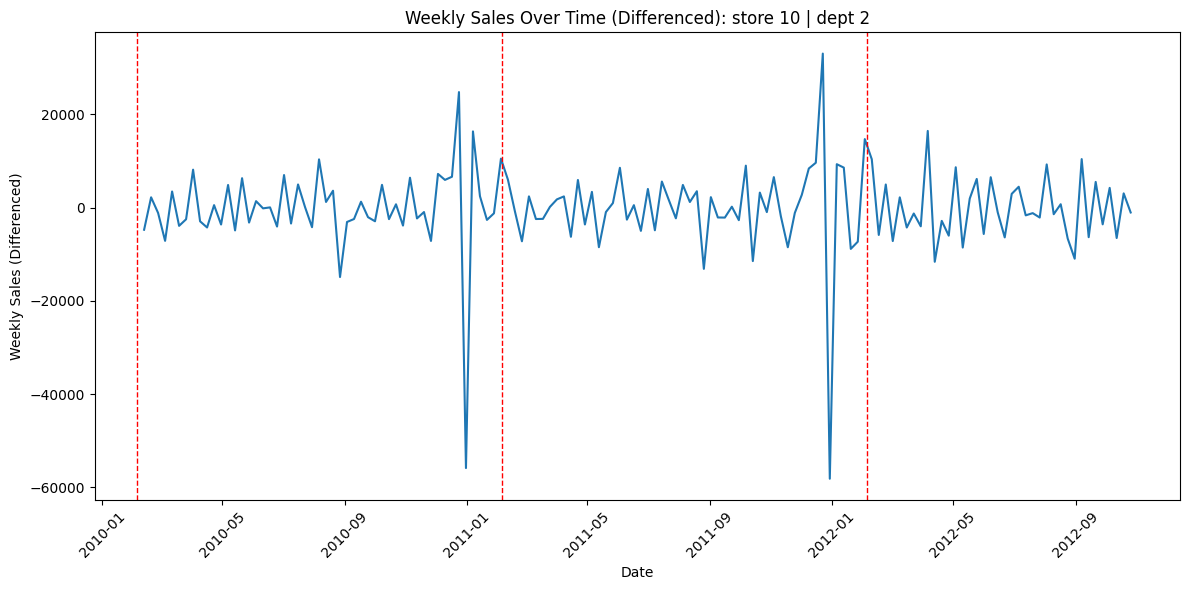

In [18]:
store_id = 10
dept_id = 2

store_dept_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]
store_sales_over_time = store_dept_df.groupby('Date')['Weekly_Sales'].sum()
store_sales_over_time_diff = store_sales_over_time.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(store_sales_over_time_diff.index, store_sales_over_time_diff.values)
plt.xlabel('Date')
plt.ylabel(f'Weekly Sales (Differenced)')
plt.title(f'Weekly Sales Over Time (Differenced): store {store_id} | dept {dept_id}')
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for the end of each year
years = pd.to_datetime(store_sales_over_time_diff.index).year.unique()
for year in years:
    end_of_year = pd.to_datetime(f'{year}-02-05')
    plt.axvline(end_of_year, color='red', linestyle='--', lw=1)

plt.show()

# ACF

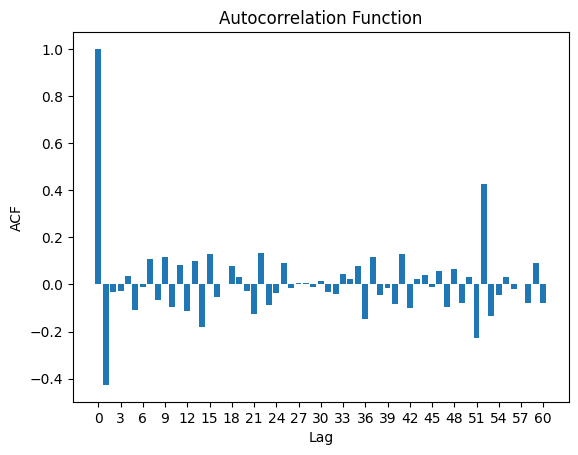

In [19]:
acf_vals = acf(store_sales_over_time_diff, nlags=60)
num_lags = len(acf_vals)
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')
plt.xticks(np.arange(0, num_lags, 3))

plt.show()

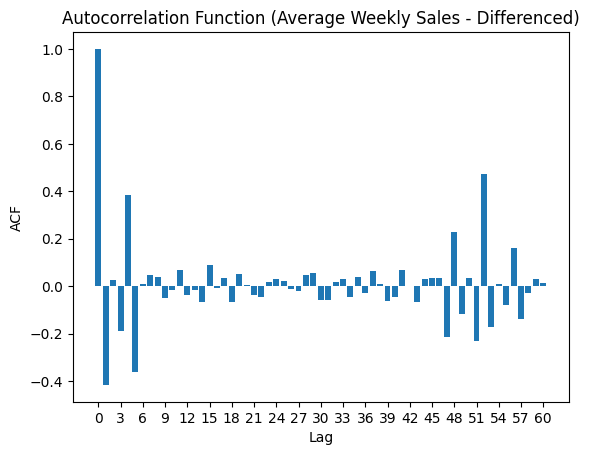

In [28]:
acf_vals_avg = acf(avg_sales_over_time_diff, nlags=60)
num_lags_avg = len(acf_vals_avg)
plt.bar(range(num_lags_avg), acf_vals_avg[:num_lags_avg])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (Average Weekly Sales - Differenced)')
plt.xticks(np.arange(0, num_lags_avg, 3))

plt.show()

# PACF

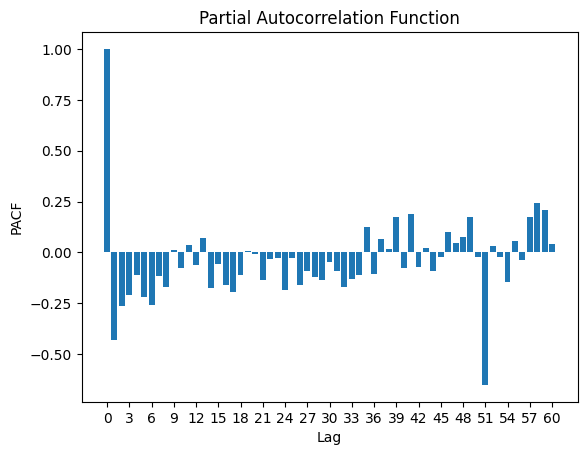

In [20]:
pacf_vals = pacf(store_sales_over_time_diff, nlags=60)
num_lags = len(pacf_vals)
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')
plt.xticks(np.arange(0, num_lags, 3))

plt.show()

# Split


In [22]:
train_end_date = pd.to_datetime('2012-02-03')

df_train = df[df['Date'] < train_end_date]
df_val = df[df['Date'] >= train_end_date]

In [27]:
store_id = 3
dept_id = 3

sd_train_df = df_train[(df_train['Store'] == store_id) & (df_train['Dept'] == dept_id)]
sd_train_df = sd_train_df.set_index('Date')
sd_val_df = df_val[(df_val['Store'] == store_id) & (df_val['Dept'] == dept_id)]
sd_val_df = sd_val_df.set_index('Date')

sd_train_df['Weekly_Sales'] = sd_train_df['Weekly_Sales'].diff().dropna()
sd_val_df['Weekly_Sales'] = sd_val_df['Weekly_Sales'].diff().dropna()

# Fill NaN

In [ ]:
class CleaningPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, nan_vars):
        self.nan_vars = nan_vars

    def fit(self, X, y=None):
        self.var_to_mean = {}
        for var in self.nan_vars:
            self.var_to_mean[var] = X[var].mean()

        return self

    def transform(self, X):
        X = X.copy()

        for var in self.nan_vars:
            X[var].fillna(self.var_to_mean[var], inplace=True)

        return X

In [ ]:
nan_vars = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Encode Categorical Variables

In [ ]:
class EncoderPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Type'] = X['Type'].astype('category').cat.codes
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)
        return X

# Fit Model

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('cleaner', CleaningPreprocessor(nan_vars=nan_vars)),
    ('encoder', EncoderPreprocessor())
])

In [ ]:
pipeline.fit(store_sales_over_time_diff)
sd_train_df = pipeline.transform(sd_train_df)
sd_val_df = pipeline.transform(sd_val_df)

In [ ]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 51)

exog_vars_list = ['IsHoliday_x', 'Temperature',	'Fuel_Price',
                  'MarkDown1', 'MarkDown2',	'MarkDown3', 'MarkDown4',	'MarkDown5',
                  'CPI',	'Unemployment',	'Type',	'Size']

exog_vars_train = sd_train_df[exog_vars_list]

model = SARIMAX(
    sd_train_df['Weekly_Sales'],
    exog=exog_vars_train,
    order=my_order,
    seasonal_order=my_seasonal_order
)

In [ ]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

KeyboardInterrupt: 

In [ ]:
print(model_fit.summary())

NameError: name 'model_fit' is not defined

In [ ]:
exog_vars_val = sd_val_df[exog_vars_list]
predictions = model_fit.forecast(len(sd_val_df), exog=exog_vars_val)
predictions = pd.Series(predictions, index=sd_val_df.index)
residuals = sd_val_df['Weekly_Sales'].values - predictions.values
residuals = pd.Series(residuals, index=sd_val_df.index)

NameError: name 'model_fit' is not defined

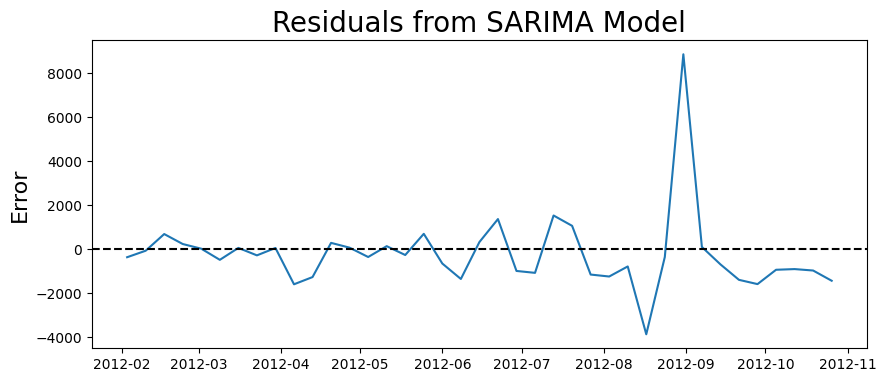

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.savefig(f'residuals_from_sarima_{store_id}_{dept_id}.png')

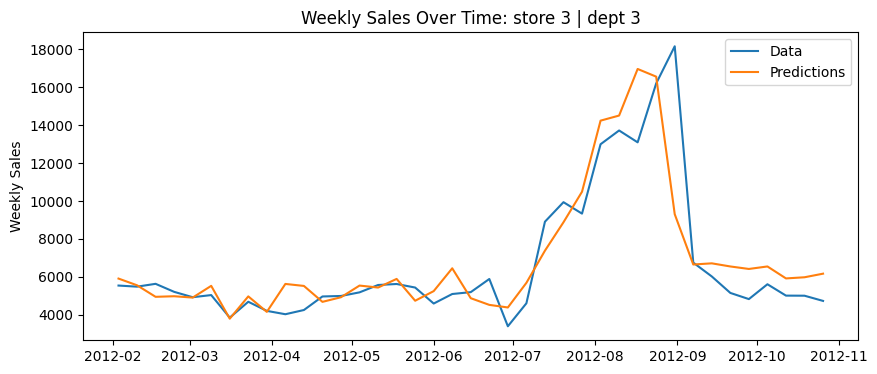

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(sd_val_df['Weekly_Sales'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'))

plt.title(f'Weekly Sales Over Time: store {store_id} | dept {dept_id}')
plt.ylabel('Weekly Sales')
plt.savefig(f'weekly_sales_over_time_{store_id}_{dept_id}.png')

# Grid Search

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error

def sarimax_grid_search(y, exog, p, d, q, P, D, Q, S, store_id, dept_id):
    best_wmae = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Generate all possible combinations of p, d, q
    pdq = list(itertools.product(p, d, q))
    # Generate all possible combinations of P, D, Q
    seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(P, D, Q))]

    print('Running Grid Search...')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(y,
                                exog=exog,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                model_fit = model.fit(disp=False) # disp=False to suppress convergence output

                # Make predictions on the validation set
                exog_val = sd_val_df[exog_vars_list] # Use the preprocessed validation exogenous variables
                predictions = model_fit.forecast(steps=len(sd_val_df), exog=exog_val)

                # Ensure predictions are positive if weekly sales should be positive
                predictions[predictions < 0] = 0

                # Evaluate the model using WMAE
                wmae = WMAE(sd_val_df, sd_val_df['Weekly_Sales'], predictions)

                # Print the WMAE
                print(f'SARIMAX({param})x({param_seasonal}) - WMAE: {wmae:.3f}')

                if wmae < best_wmae:
                    best_wmae = wmae
                    best_order = param
                    best_seasonal_order = param_seasonal
                    best_model = model_fit

            except Exception as e:
                print(f'Could not fit SARIMAX({param})x({param_seasonal}): {e}')
                continue

    print('\nBest SARIMAX Model:')
    print(f'Order: {best_order}')
    print(f'Seasonal Order: {best_seasonal_order}')
    print(f'Validation WMAE: {best_wmae:.3f}')

    return best_order, best_seasonal_order, best_wmae, best_model

In [ ]:
# Define parameter ranges for grid search
p = range(0, 3) # p values for the non-seasonal part
d = range(0, 2) # d values for the non-seasonal differencing
q = range(0, 3) # q values for the non-seasonal part
P = range(0, 3) # P values for the seasonal part
D = range(0, 2) # D values for the seasonal differencing
Q = range(0, 3) # Q values for the seasonal part
S = 52        # Seasonal period (51 weeks in a year)

# Select the time series data and exogenous variables for training
y_train = sd_train_df['Weekly_Sales']
exog_train = sd_train_df[exog_vars_list]

# Run the grid search
best_order, best_seasonal_order, best_wmae, best_model = sarimax_grid_search(
    y_train,
    exog_train,
    p, d, q,
    P, D, Q, S,
    store_id,
    dept_id
)

Running Grid Search...
SARIMAX((0, 0, 0))x((0, 0, 0, 52)) - WMAE: 4410.815
SARIMAX((0, 0, 0))x((0, 0, 1, 52)) - WMAE: 19343.302
SARIMAX((0, 0, 0))x((0, 0, 2, 52)) - WMAE: 2847.444
SARIMAX((0, 0, 0))x((0, 1, 0, 52)) - WMAE: 1159.093
SARIMAX((0, 0, 0))x((0, 1, 1, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((0, 1, 2, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((1, 0, 0, 52)) - WMAE: 1582.151
SARIMAX((0, 0, 0))x((1, 0, 1, 52)) - WMAE: 2342.403
SARIMAX((0, 0, 0))x((1, 0, 2, 52)) - WMAE: 2847.444
SARIMAX((0, 0, 0))x((1, 1, 0, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((1, 1, 1, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((1, 1, 2, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((2, 0, 0, 52)) - WMAE: 2847.444
SARIMAX((0, 0, 0))x((2, 0, 1, 52)) - WMAE: 2847.444
SARIMAX((0, 0, 0))x((2, 0, 2, 52)) - WMAE: 2847.444
SARIMAX((0, 0, 0))x((2, 1, 0, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((2, 1, 1, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 0))x((2, 1, 2, 52)) - WMAE: 1147.824
SARIMAX((0, 0, 1))x((0, 0, 0, 52)) - WMA

In [ ]:
exog_vars_val = sd_val_df[exog_vars_list]
predictions = best_model.forecast(len(sd_val_df), exog=exog_vars_val)
predictions = pd.Series(predictions, index=sd_val_df.index)
residuals = sd_val_df['Weekly_Sales'].values - predictions.values
residuals = pd.Series(residuals, index=sd_val_df.index)

# Start MLFlow

In [ ]:
!pip install dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import dagshub
import mlflow
from mlflow.models.signature import infer_signature
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=4c093bef-0a12-4930-8c4e-90bfbe736475&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=fd1b0f3286ab083dde56113764774049b0851bdb814f232a8a8edb1fb4d77aa7




Accessing as Cimbir

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [ ]:
mlflow.set_experiment('SARIMA_Training')

<Experiment: artifact_location='mlflow-artifacts:/eab27d284ccf4e2c9217f41e9914a0b4', creation_time=1751109185006, experiment_id='0', last_update_time=1751109185006, lifecycle_stage='active', name='SARIMA_Training', tags={}>

In [ ]:
with mlflow.start_run(run_name='SARIMA_Preprocessor') as run:
  mlflow.log_param('cleaner', 'CleaningPreprocessor')
  mlflow.log_param('nan_vars', nan_vars)
  mlflow.log_param('encoder', 'EncoderPreprocessor')

  pickle.dump(pipeline, open('preprocessor_pipeline.pkl', 'wb'))
  mlflow.log_artifact('preprocessor_pipeline.pkl')

🏃 View run SARIMA_Preprocessor at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0/runs/2b847b20f52d4dea8f1a01a935b3faf3
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0


In [ ]:
with mlflow.start_run(run_name=f'SARIMA_Model_{store_id}_{dept_id}_s_{S}') as run:
  mlflow.log_param('store_id', store_id)
  mlflow.log_param('dept_id', dept_id)

  mlflow.log_param('p', p)
  mlflow.log_param('d', d)
  mlflow.log_param('q', q)
  mlflow.log_param('P', P)
  mlflow.log_param('D', D)
  mlflow.log_param('Q', Q)
  mlflow.log_param('S', S)

  mlflow.log_param('exog_vars_list', exog_vars_list)

  mlflow.log_param('best_order', best_order)
  mlflow.log_param('best_seasonal_order', best_seasonal_order)
  mlflow.log_metric('best_wmae', best_wmae)

  mlflow.log_text(str(best_model.summary()), 'model_summary.txt')

  # Save the best_model using pickle and log it as an artifact
  pickle.dump(best_model, open('sarima_best_model.pkl', 'wb'))
  mlflow.log_artifact('sarima_best_model.pkl')

  # predictions_val = best_model.forecast(steps=len(sd_val_df), exog=sd_val_df[exog_vars_list])
  # predictions_val[predictions_val < 0] = 0
  # signature = infer_signature(sd_val_df[exog_vars_list], predictions_val)
  # mlflow.statsmodels.log_model(best_model, 'sarima_model', signature=signature)

  mlflow.log_artifact(f'residuals_from_sarima_{store_id}_{dept_id}.png')
  mlflow.log_artifact(f'weekly_sales_over_time_{store_id}_{dept_id}.png')

🏃 View run SARIMA_Model_3_3_s_52 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0/runs/4f44b8799a674e1aaddf996397872d91
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0
